In [86]:
import pandas as pd
df = pd.read_csv("german.data",header=None)

In [87]:
df = pd.DataFrame(df[0].str.split(" ",20).tolist(),columns = ["Acc Status", "Duration", "History","Purpose",
                                                             "Amount","Savings","Employment","InstRate",
                                                             "PersonalStatus","Debtors","ResidentSince",
                                                             "Property","Age","OtherPlans","Housing",
                                                             "ExistingCredits","Job","NoLiable","Telephone",
                                                             "Foreign","Outcome"])

In [89]:
df.Outcome = df.Outcome.replace("1",0)
df.Outcome = df.Outcome.replace("2",1)

In [90]:
print(df)

    Acc Status Duration History Purpose Amount Savings Employment InstRate  \
0          A11        6     A34     A43   1169     A65        A75        4   
1          A12       48     A32     A43   5951     A61        A73        2   
2          A14       12     A34     A46   2096     A61        A74        2   
3          A11       42     A32     A42   7882     A61        A74        2   
4          A11       24     A33     A40   4870     A61        A73        3   
..         ...      ...     ...     ...    ...     ...        ...      ...   
995        A14       12     A32     A42   1736     A61        A74        3   
996        A11       30     A32     A41   3857     A61        A73        4   
997        A14       12     A32     A43    804     A61        A75        4   
998        A11       45     A32     A43   1845     A61        A73        4   
999        A12       45     A34     A41   4576     A62        A71        3   

    PersonalStatus Debtors  ... Property Age OtherPlans Housing

In [91]:
df = df.astype({"Duration": int, "Amount":int, "InstRate": int, "ResidentSince": int, "Age": int, "ExistingCredits": int, "NoLiable": int})

### Logistic Regression

In [96]:
import sklearn
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble 
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline

#dummy variables for categoricals
mod_data = pd.get_dummies(df)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mod_data.drop("Outcome",axis = "columns"),mod_data["Outcome"],test_size = 0.2)

In [97]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(penalty = "none", fit_intercept=False,max_iter=10000)

lrmod = logr.fit(X_train,y_train)

In [98]:
from sklearn.metrics import confusion_matrix
y_pred_lr = logr.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_lr)
cnf_matrix

array([[120,  21],
       [ 28,  31]])

In [101]:
import sklearn.metrics as metrics


print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))
print("Precision:",metrics.precision_score(y_test, y_pred_lr))
print("Recall:",metrics.recall_score(y_test, y_pred_lr))

Accuracy: 0.755
Precision: 0.5961538461538461
Recall: 0.5254237288135594


In [102]:
probs_lr = lrmod.predict_proba(X_test)[:,1]

sklearn.metrics.roc_auc_score(y_true=y_test, y_score=probs_lr)

0.7950474816684698

Precision and recall are poor and it seems like there is room for improvement with the AUC and accuracy. 

### Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [104]:
model.score(X_test,y_test)

0.755

In [105]:
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,y_pred)
matrix

array([[131,  10],
       [ 39,  20]])

In [106]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.755
Precision: 0.6666666666666666
Recall: 0.3389830508474576


In [107]:
probs_rf = model.predict_proba(X_test)[:,1]

sklearn.metrics.roc_auc_score(y_true=y_test, y_score=probs_rf)

0.8016588532275514

AUC for untuned random forest is acually slightly better than for logistic, need to still tune and see what happens. Precision is better but recall is worse.

### CausalNex

In [27]:
import numpy as np
struct_data = df.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['Acc Status', 'History', 'Purpose', 'Savings', 'Employment', 'PersonalStatus', 'Debtors', 'Property', 'OtherPlans', 'Housing', 'Job', 'Telephone', 'Foreign', 'Outcome']


In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,Acc Status,Duration,History,Purpose,Amount,Savings,Employment,InstRate,PersonalStatus,Debtors,...,Property,Age,OtherPlans,Housing,ExistingCredits,Job,NoLiable,Telephone,Foreign,Outcome
0,0,6,4,4,1169,4,4,4,2,0,...,0,67,2,1,2,2,1,1,0,0
1,1,48,2,4,5951,0,2,2,1,0,...,0,22,2,1,1,2,1,0,0,1
2,3,12,4,7,2096,0,3,2,2,0,...,0,49,2,1,1,1,2,0,0,0
3,0,42,2,3,7882,0,3,2,2,2,...,1,45,2,2,1,2,2,0,0,0
4,0,24,3,0,4870,0,2,3,2,0,...,3,53,2,2,2,2,2,0,0,1


In [36]:
normalized_df=(struct_data-struct_data.mean())/struct_data.std()
normalized_df

,Acc Status,Duration,History,Purpose,Amount,Savings,Employment,InstRate,PersonalStatus,Debtors,...,Property,Age,OtherPlans,Housing,ExistingCredits,Job,NoLiable,Telephone,Foreign,Outcome
0,-1.253938,-1.235859,1.343342,0.263936,-0.744759,1.832252,1.337409,0.918018,0.449102,-0.303534,...,-1.293076,2.765073,0.4606,0.133644,1.026565,0.146876,-0.428075,1.213990,-0.195916,-0.654326
1,-0.458797,2.247070,-0.503176,0.263936,0.949342,-0.699357,-0.317800,-0.869748,-0.963168,-0.303534,...,-1.293076,-1.190808,0.4606,0.133644,-0.704573,0.146876,-0.428075,-0.822906,-0.195916,1.526761
2,1.131486,-0.738298,1.343342,1.359105,-0.416354,-0.699357,0.509805,-0.869748,0.449102,-0.303534,...,-1.293076,1.182721,0.4606,0.133644,-0.704573,-1.383079,2.333701,-0.822906,-0.195916,-0.654326
3,-1.253938,1.749509,-0.503176,-0.101121,1.633430,-0.699357,0.509805,-0.869748,0.449102,3.883140,...,-0.340885,0.831087,0.4606,2.015948,-0.704573,0.146876,2.333701,-0.822906,-0.195916,-0.654326
4,-1.253938,0.256825,0.420083,-1.196290,0.566380,-0.699357,-0.317800,0.024135,0.449102,-0.303534,...,1.563498,1.534354,0.4606,2.015948,1.026565,0.146876,2.333701,-0.822906,-0.195916,1.526761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.131486,-0.738298,-0.503176,-0.101121,-0.543890,-0.699357,0.509805,0.024135,-0.963168,-0.303534,...,-1.293076,-0.399632,0.4606,0.133644,-0.704573,-1.383079,-0.428075,-0.822906,-0.195916,-0.654326
996,-1.253938,0.754386,-0.503176,-0.831234,0.207509,-0.699357,-0.317800,0.918018,-2.375438,-0.303534,...,-0.340885,0.391544,0.4606,0.133644,-0.704573,1.676831,-0.428075,1.213990,-0.195916,-0.654326
997,1.131486,-0.738298,-0.503176,0.263936,-0.874066,-0.699357,1.337409,0.918018,0.449102,-0.303534,...,0.611307,0.215727,0.4606,0.133644,-0.704573,0.146876,-0.428075,-0.822906,-0.195916,-0.654326
998,-1.253938,1.998289,-0.503176,0.263936,-0.505275,-0.699357,-0.317800,0.918018,0.449102,-0.303534,...,1.563498,-1.102900,0.4606,2.015948,-0.704573,0.146876,-0.428075,1.213990,-0.195916,1.526761


In [30]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(struct_data,max_iter = 400)

/Users/tomgvero/opt/anaconda3/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'Acc Status', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


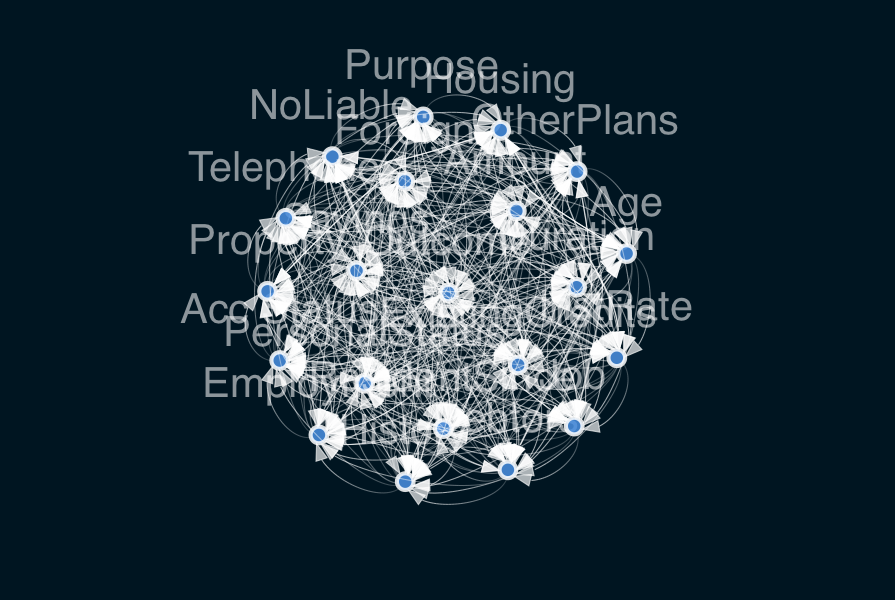

In [31]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

/Users/tomgvero/opt/anaconda3/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'Acc Status', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


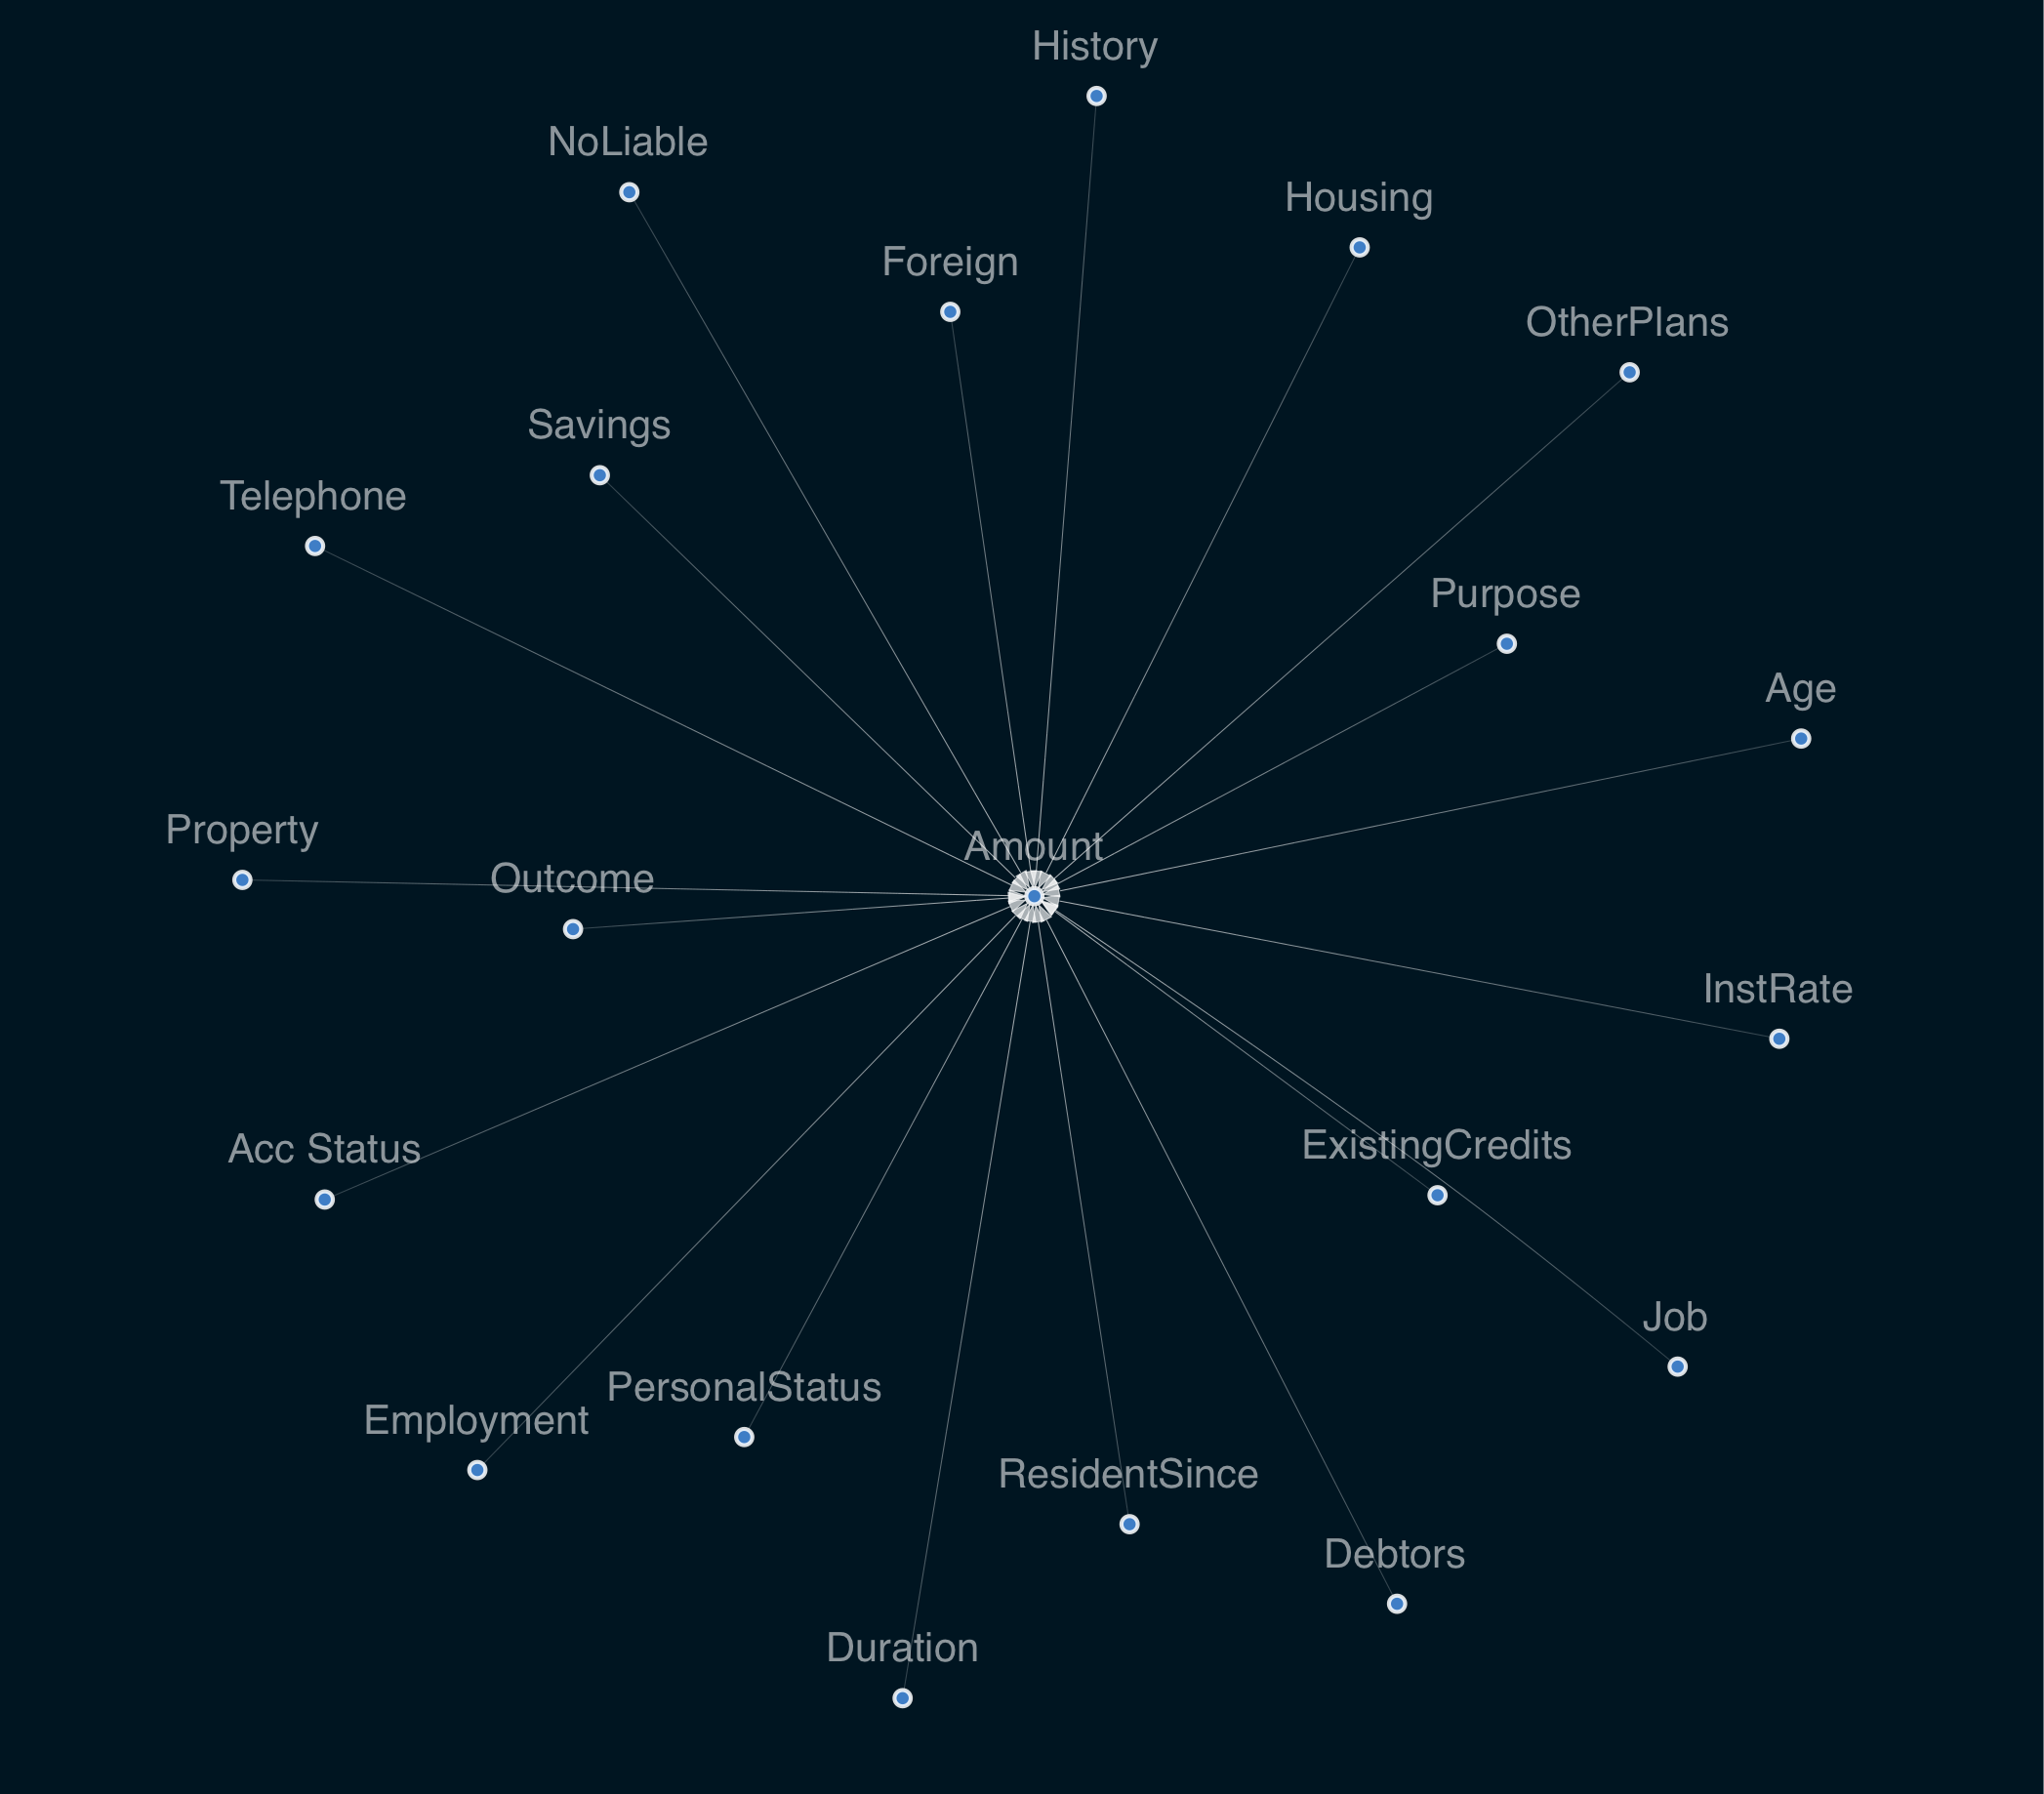

In [35]:
sm.remove_edges_below_threshold(10)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [41]:
from causalnex.structure.notears import from_pandas
sm_norm = from_pandas(normalized_df,max_iter = 400)

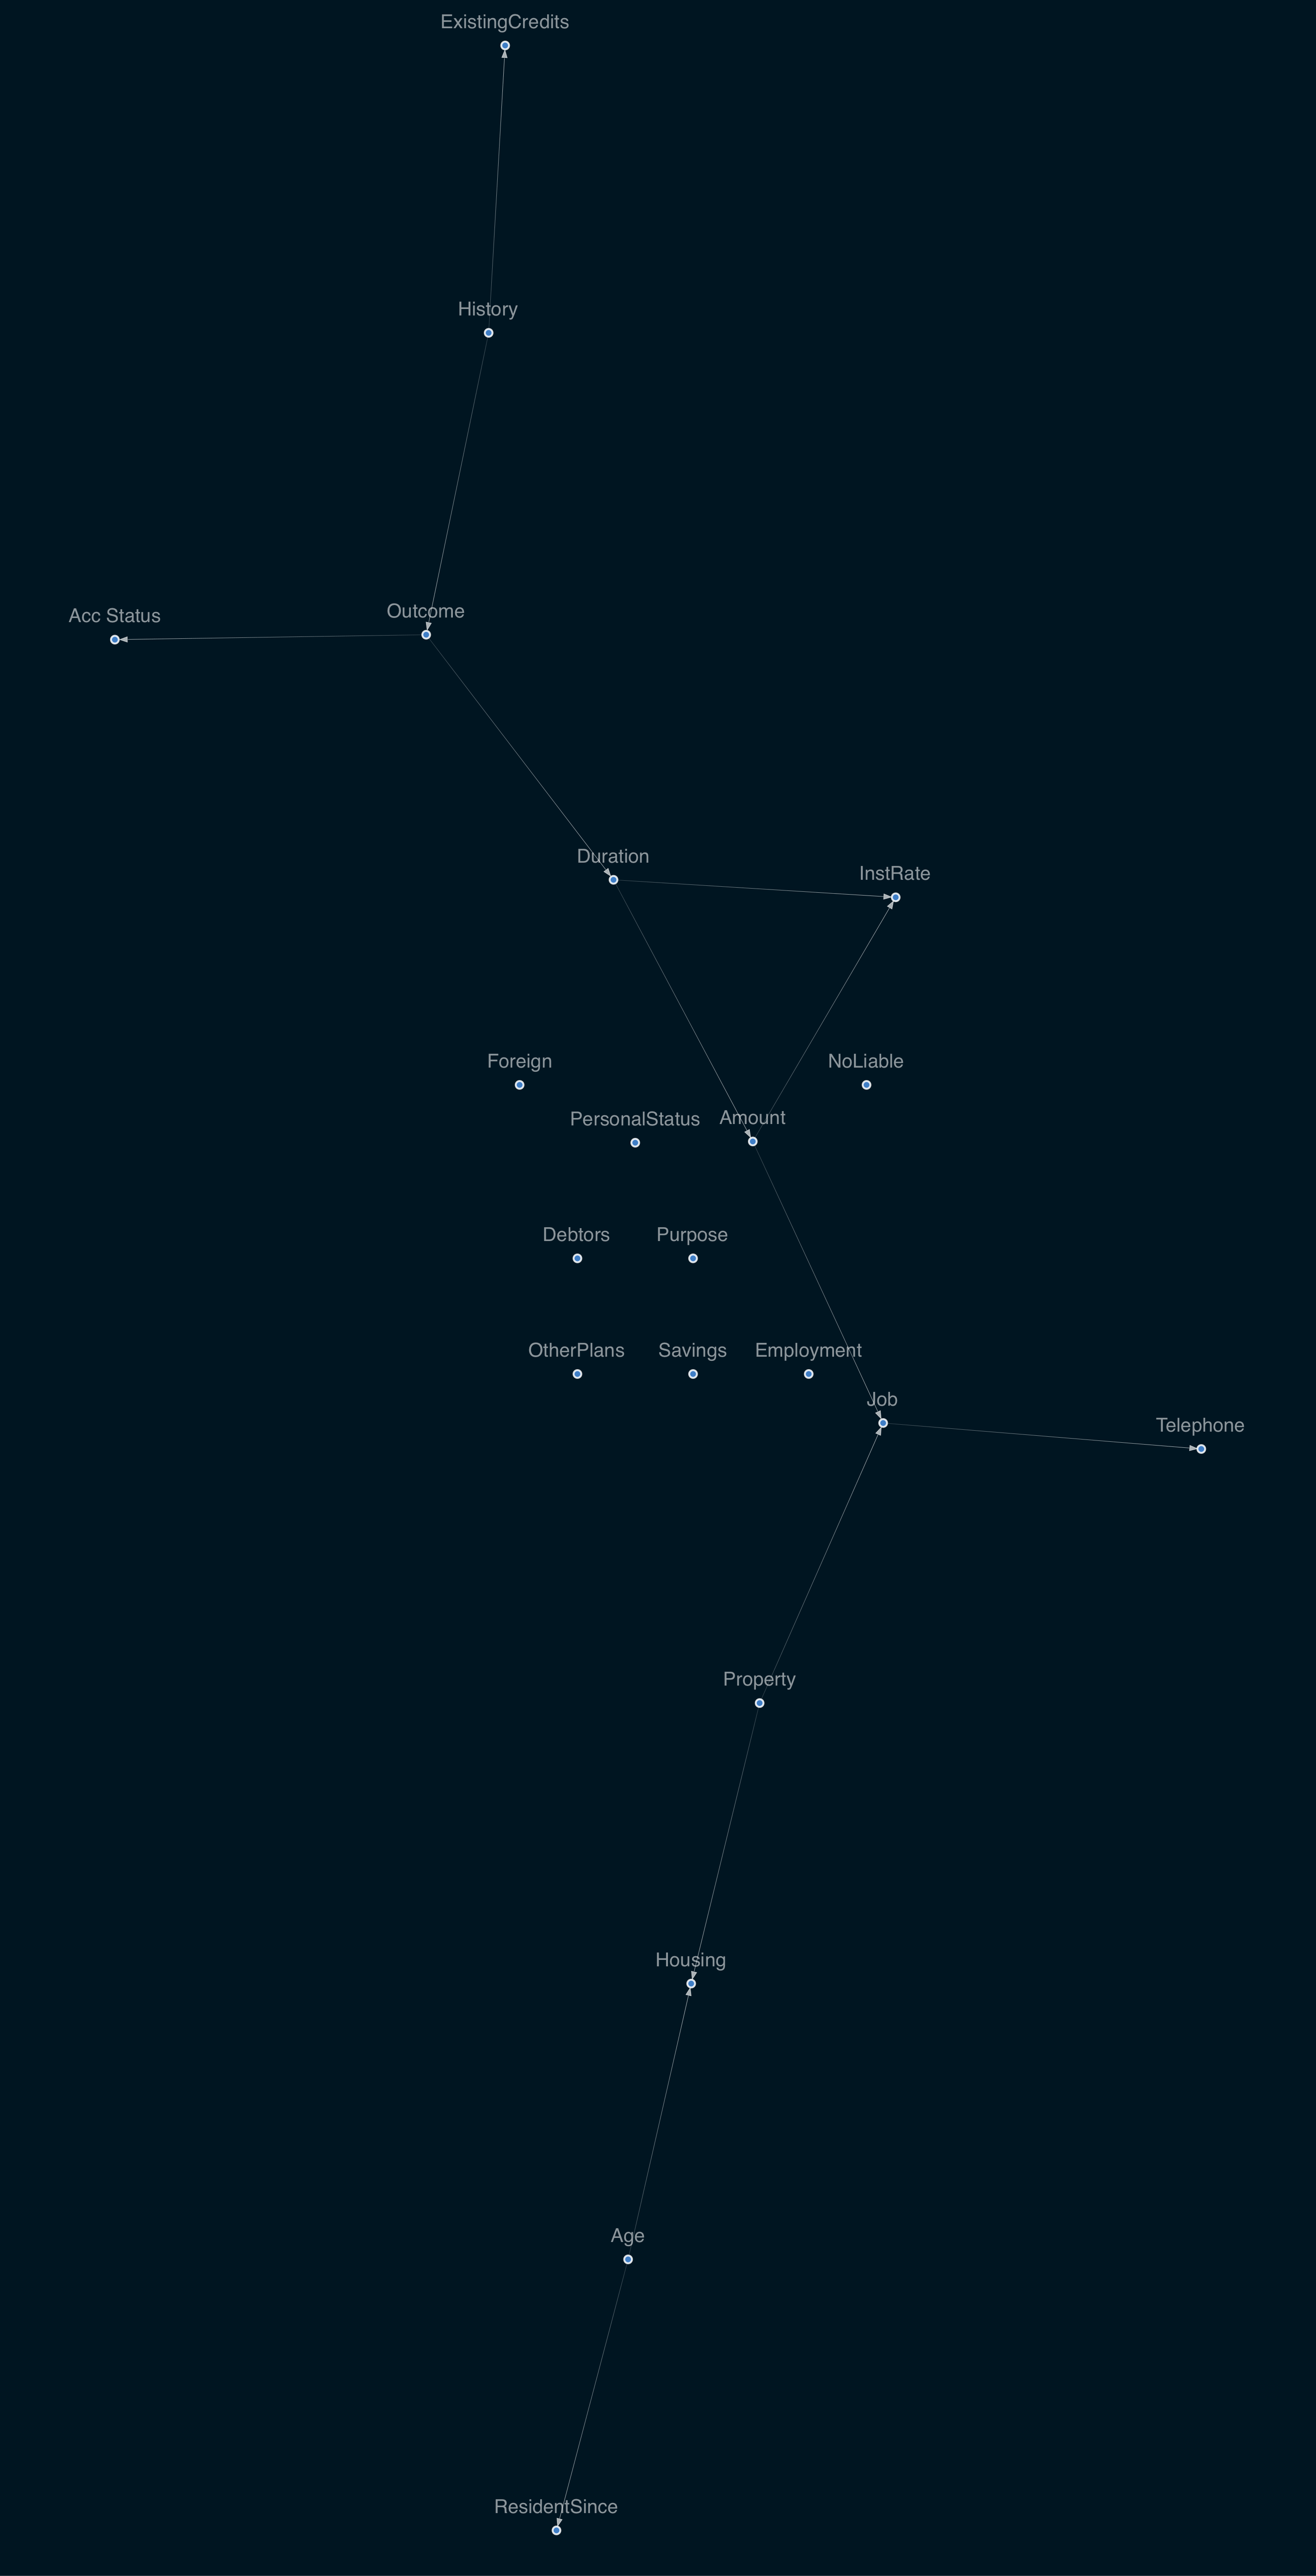

In [43]:
sm_norm.remove_edges_below_threshold(0.2)
viz = plot_structure(
    sm_norm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [ ]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm_norm)

In [114]:
df_slim = df.drop(columns=["Foreign","PersonalStatus","Debtors","Purpose","OtherPlans","Savings","Employment","NoLiable"])

In [115]:
df_slim

,Acc Status,Duration,History,Amount,InstRate,ResidentSince,Property,Age,Housing,ExistingCredits,Job,Telephone,Outcome
0,A11,6,A34,1169,4,4,A121,67,A152,2,A173,A192,0
1,A12,48,A32,5951,2,2,A121,22,A152,1,A173,A191,1
2,A14,12,A34,2096,2,3,A121,49,A152,1,A172,A191,0
3,A11,42,A32,7882,2,4,A122,45,A153,1,A173,A191,0
4,A11,24,A33,4870,3,4,A124,53,A153,2,A173,A191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,1736,3,4,A121,31,A152,1,A172,A191,0
996,A11,30,A32,3857,4,4,A122,40,A152,1,A174,A192,0
997,A14,12,A32,804,4,4,A123,38,A152,1,A173,A191,0
998,A11,45,A32,1845,4,4,A124,23,A153,1,A173,A192,1


In [116]:
mod2_data = pd.get_dummies(df_slim)



In [118]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(mod2_data.drop("Outcome",axis = "columns"),mod2_data["Outcome"],test_size = 0.2)

In [120]:
logr2 = LogisticRegression(penalty = "none", fit_intercept=False,max_iter=10000)

lrmod2 = logr2.fit(X_train2,y_train2)

y_pred_lr2 = logr2.predict(X_test2)

print("Accuracy:",metrics.accuracy_score(y_test2, y_pred_lr2))
print("Precision:",metrics.precision_score(y_test2, y_pred_lr2))
print("Recall:",metrics.recall_score(y_test2, y_pred_lr2))

Accuracy: 0.76
Precision: 0.5652173913043478
Recall: 0.48148148148148145


In [121]:
struct_data

,Acc Status,Duration,History,Purpose,Amount,Savings,Employment,InstRate,PersonalStatus,Debtors,...,Property,Age,OtherPlans,Housing,ExistingCredits,Job,NoLiable,Telephone,Foreign,Outcome
0,0,6,4,4,1169,4,4,4,2,0,...,0,67,2,1,2,2,1,1,0,0
1,1,48,2,4,5951,0,2,2,1,0,...,0,22,2,1,1,2,1,0,0,1
2,3,12,4,7,2096,0,3,2,2,0,...,0,49,2,1,1,1,2,0,0,0
3,0,42,2,3,7882,0,3,2,2,2,...,1,45,2,2,1,2,2,0,0,0
4,0,24,3,0,4870,0,2,3,2,0,...,3,53,2,2,2,2,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,12,2,3,1736,0,3,3,1,0,...,0,31,2,1,1,1,1,0,0,0
996,0,30,2,1,3857,0,2,4,0,0,...,1,40,2,1,1,3,1,1,0,0
997,3,12,2,4,804,0,4,4,2,0,...,2,38,2,1,1,2,1,0,0,0
998,0,45,2,4,1845,0,2,4,2,0,...,3,23,2,2,1,2,1,1,0,1


In [122]:
#remove amounts column which is skewing graph
test = struct_data.drop(columns=["Amount"])
test

,Acc Status,Duration,History,Purpose,Savings,Employment,InstRate,PersonalStatus,Debtors,ResidentSince,Property,Age,OtherPlans,Housing,ExistingCredits,Job,NoLiable,Telephone,Foreign,Outcome
0,0,6,4,4,4,4,4,2,0,4,0,67,2,1,2,2,1,1,0,0
1,1,48,2,4,0,2,2,1,0,2,0,22,2,1,1,2,1,0,0,1
2,3,12,4,7,0,3,2,2,0,3,0,49,2,1,1,1,2,0,0,0
3,0,42,2,3,0,3,2,2,2,4,1,45,2,2,1,2,2,0,0,0
4,0,24,3,0,0,2,3,2,0,4,3,53,2,2,2,2,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,12,2,3,0,3,3,1,0,4,0,31,2,1,1,1,1,0,0,0
996,0,30,2,1,0,2,4,0,0,4,1,40,2,1,1,3,1,1,0,0
997,3,12,2,4,0,4,4,2,0,4,2,38,2,1,1,2,1,0,0,0
998,0,45,2,4,0,2,4,2,0,4,3,23,2,2,1,2,1,1,0,1


In [123]:
sm_test = from_pandas(test,max_iter = 400)

/Users/tomgvero/opt/anaconda3/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'Acc Status', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


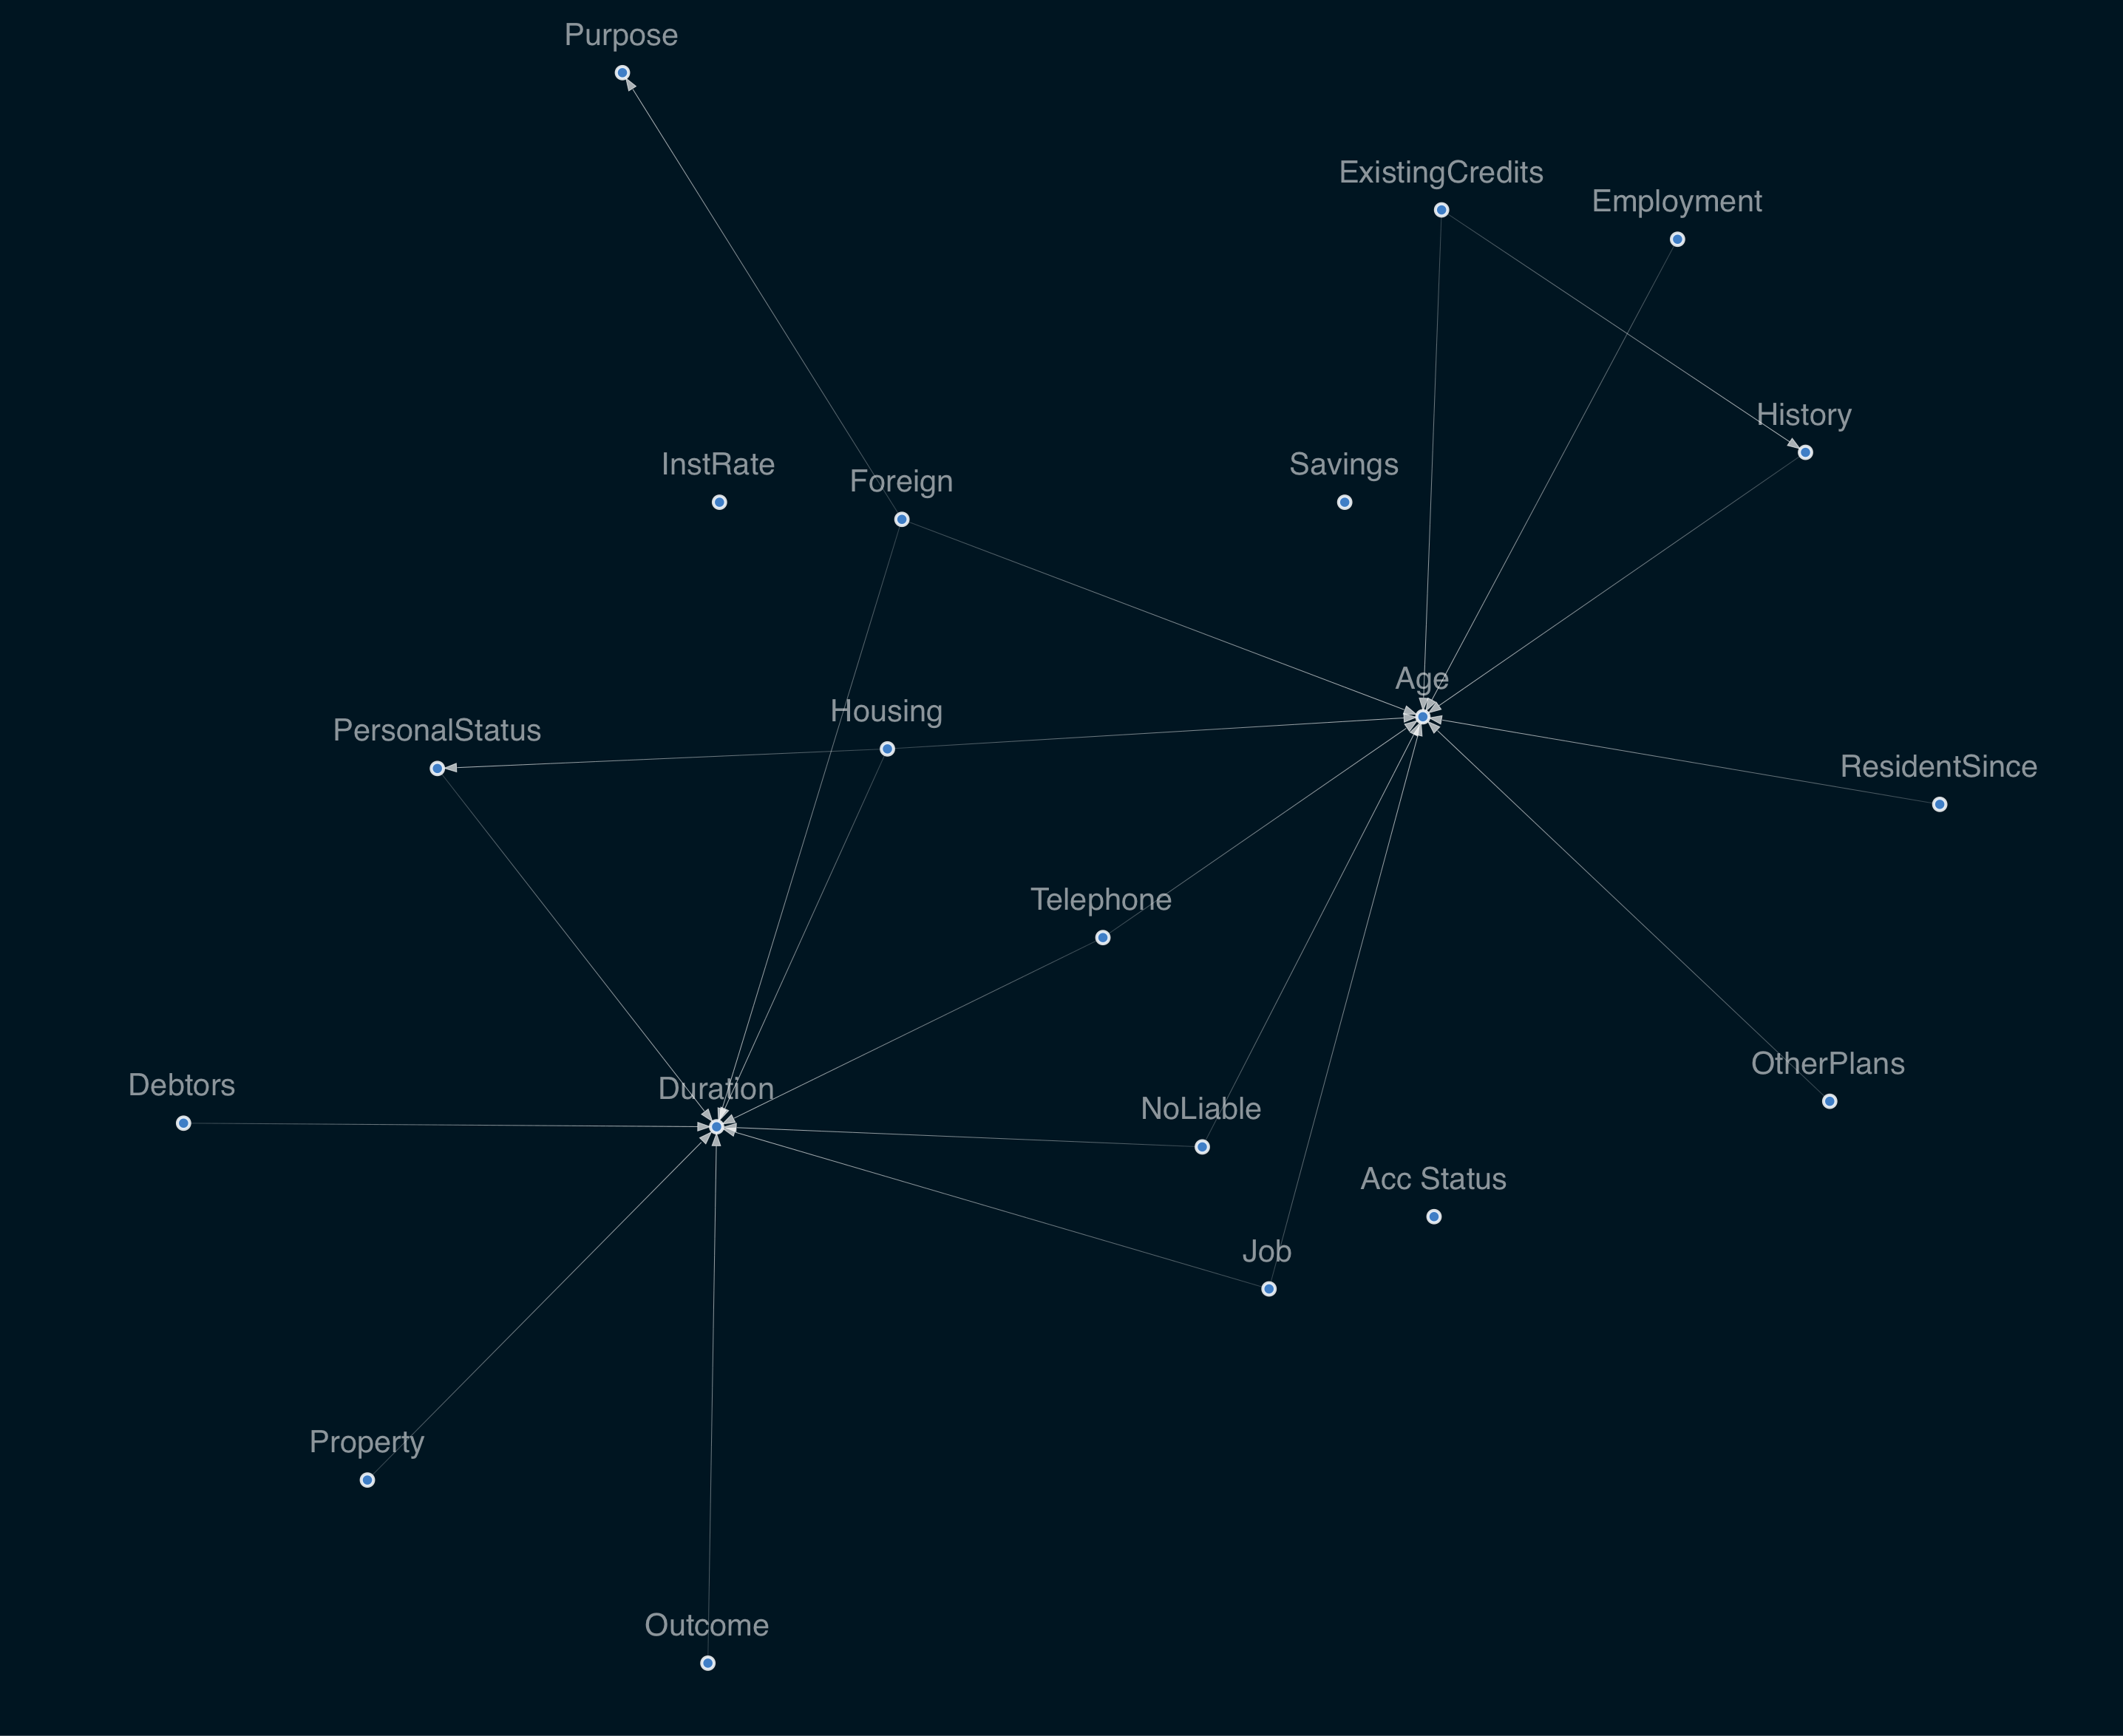

In [126]:
sm_test.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm_test,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))